# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision
---
#### Tal Daniel

## Tutorial 13 - Generative Adversarial Networks (GANs)
---

<img src="./assets/tut_gan_morphing.gif" style="height:200px">

* <a href="https://becominghuman.ai/with-gans-world-s-first-ai-generated-painting-to-recent-advancement-of-nvidia-b08ddfda45b1">Image Source</a>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---

* [What are Generative Adversarial Networks?](#-What-Are-Generative-Adversarial-Networks-(GANs)?)
    * [Discriminative Vs. Generative](#-Discriminative-vs.-Generative)
    * [Adversarial Training](#-Adversarial-Training)
    * [A Game Theory Perspective - Nash Equilibrium](#-GANs---A-Game-Theory-Persepective---Nash-Equilibrium)
* [GANs Training Steps](#-GANs-Training-Steps)
    * Formulation
    * Algorithm
* [2D Demo](#-2D-Demo)
* [GANs (Serious) Problems](#-GANs-(Serious)-Problems)


* [Vanilla-GAN on MNIST with PyTorch](#-Vanilla-GAN-on-MNIST-with-PyTorch)
* [Deep Convolutional GANs (DCGANs)](#-Deep-Convolutional-GANs-(DCGANs))
* [The Latent Space](#-The-Latent-Space)
* [Conditional GANs](#-Conditional-GANs)
* [GANs Today](#-GANs-Today)
* [Tips for Training GANs](#-Tips-for-Training-GANs)
* [Applications](#-Applications)
    * [Image-to-Image Translation (Pix2Pix)](#-Image-to-Image-Translation-(Pix2Pix))
    * [CycleGAN](#-CycleGAN)
    * [Realistic Neural Talking Head Models](#-Realistic-Neural-Talking-Head-Models)
    * [Face Aging with Conditional GANs](#-Face-Aging-with-Conditional-GANs)
* [Cool GAN Projects (with Code)](#-Cool-GAN-Projects-(with-Code))
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

In [1]:
# imports for the tutorial
import time
import numpy as np
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

##  <img src="./assets/mnist_anim_icon.gif" style="height:40px;display:inline"> What Are Generative Adversarial Networks (GANs)?
---
* **Generative** - learn a generative model that can generate new data.
* **Adversarial** - trained in an *adversarial* setting (there is some competition during the model's training).
* **Networks** - the model is implemented using deep neural networks.

GANs were first introduced in <a href="http://papers.nips.cc/paper/5423-generative-adversarial-nets">Generative Adversarial Networks</a>, NIPS 2014, by Goodfellow et al.

### <img src="https://img.icons8.com/nolan/64/resize-horizontal.png" style="height:50px;display:inline"> Discriminative vs. Generative
---
* So far, we have only seen *discriminative* models
    * Given an image $X$, predict a label $Y$
    * That is, we learn $P(Y\mid X)$
* The problem with discriminative models:
    * During training, labels are required, as it is a *supervised* setting.
    * Can't model $P(X)$, i.e., the probability of seeing a certain image.
    * As a result, can't *sample* from $P(X)$, i.e., **can't generate new images**.
* **Generative** models can overcome these limitations!
    * They can model $P(X)$, implicitly (e.g. GANs) or explicitly (e.g. Variational Autoencoders - VAEs).
    * Given a trained model, can generate new images (or data in general).

<img src="./assets/tut_gan_taxonomy.jpg" style="height:350px">

<a href="https://arxiv.org/abs/1701.00160">Image Source</a>

* **Explicit** density estimation: explicitly define and solve for $p_{model}(x)$.
* **Implicit** density estimation: learn a model that can sample from $p_{model}(x)$ without explicitly defining it.

### <img src="https://img.icons8.com/ios/50/000000/battle.png" style="height:50px;display:inline"> Adversarial Training
---
* **Goal**: given training data, generate new samples from the same distribution.
<img src="./assets/tut_gan_train_to_sample.PNG" style="height:250px">

* In **general adversarial setting** (can also be discriminative):
    * We can generate adversarial samples to *fool* a dsicriminative model.
    * Using adversarial samples, we can make models more **robust**.
    * Doing this will require the adversarial samples to be of better quality over time.
        * This will require more effort in generating such quality samples!
    * Repeating this process will result in a better *discriminative* model.

<img src="./assets/tut_gan_adv_setting.png" style="height:300px">

* <a href="https://www.researchgate.net/publication/325370539_Protecting_Voice_Controlled_Systems_Using_Sound_Source_Identification_Based_on_Acoustic_Cues">Image Source</a>

* **GANs** extend this idea to *generative* models:
    * **Generator**: generate fake samples, tries to fool the *Discriminator*.
    * **Discriminator**: tries to dsitinguish between real and fake samples.
    * Train them **against** each other!
    * Repeat this and get a better *Generator* over time.

<img src="./assets/tut_gan_architecture.png" style="height:300px">

* <a href="https://www.researchgate.net/publication/334100947_Partial_Discharge_Classification_Using_Deep_Learning_Methods-Survey_of_Recent_Progress">Image Source</a>

<img src="./assets/tut_gan_gen_disc.png" style="height:300px">

* <a href="https://towardsdatascience.com/comprehensive-introduction-to-turing-learning-and-gans-part-2-fd8e4a70775">Image Source</a>

## <img src="https://img.icons8.com/plasticine/100/000000/controller.png" style="height:50px;display:inline"> GANs - A Game Theory Persepective - Nash Equilibrium
---
* GAN is based on a **zero-sum** cooperative game (minimax).
    * In short, if one wins the other loses.
* In game theory, the GAN model **converges** when the *discriminator* and the *generator* reach a **Nash equilibrium**.
* **Nash equilibrium** - as both sides want to beat the other, a Nash equilibrium happens when *one player will not change its action regardless of what the opponent may do*.
* **Cost functions may not converge using gradient descent in a minimax game**.

## <img src="https://img.icons8.com/plasticine/100/000000/workflow.png" style="height:50px;display:inline"> GANs Training Steps
---
* Training the **Discriminator**
    * **Freeze** the *Generator* and generate fake samples (that is, when backpropagating, don't update the generator weights)
    
<img src="./assets/tut_gan_train_disc.PNG" style="height:300px">

* Training the **Generator**
    * **Freeze** the *Discriminator*, and update the Generator to get a higher score (like the real data) from the Discriminator
    
<img src="./assets/tut_gan_train_gen.PNG" style="height:300px">

## <img src="https://img.icons8.com/color/96/000000/rubiks-cube.png" style="height:50px;display:inline"> Formulation & Algorithm
---
* For a Discriminator (binary classifier) $D$, a Generator $G$ and a reward function $V$, the GAN's objective function: $$ \min_G \max_D V(D,G)$$
* It is formulated as a **minimax game**, where:
    * The **Discriminator** $D$ is trying to *maximize* its reward $V(D, G)$
    * The **Generator** $G$ is trying to *minimize* the Discriminator's reward (or maximize its loss)
        * Why? Because minimizing the Discriminator's reward means that the Discriminator can not tell the difference between real and fake samples, thus, the Generator is "winning".

* In our case, the reward function $V$: $$ V(D,G) = \mathbb{E}_{x \sim p(x)} \left[ \log D(x) \right] + \mathbb{E}_{z\sim q(z)} \left[\log(1 - D\left(G(z)\right)) \right] $$
    * Recall that for binary classification (real or fake) we use the <a href="https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy">Binary Cross Entropy (BCE)</a> loss function.
* The **Nash equilibrium** is reached when:
    * $P_{data}(x) = P_{gen}(x), \forall x$
    * $D(x) = \frac{1}{2}$ (completely random classifier).
    
* <a href="https://srome.github.io/An-Annotated-Proof-of-Generative-Adversarial-Networks-with-Implementation-Notes/">Proof of Nash Equilibrium in GANs</a> - However out of the scope of this course, the mathematical proof is very nice and important. It is recommended to go over it if you are interested in working with GANs in the future.

<img src="./assets/tut_gan_gen_disc_loss.png" style="height300px">

* <a href="https://towardsdatascience.com/comprehensive-introduction-to-turing-learning-and-gans-part-2-fd8e4a70775">Image Source</a>

<img src="./assets/tut_gan_algo.PNG" style="height:500px">

## <img src="https://img.icons8.com/cute-clipart/64/000000/test-tube.png" style="height:50px;display:inline"> 2D Demo

<a href="https://poloclub.github.io/ganlab/">GAN Lab <br> <img src="./assets/tut_gan_ganlab.PNG" style="height:400px"></a>

## <img src="https://img.icons8.com/dusk/64/000000/box-important.png" style="height:50px;display:inline"> GANs (Serious) Problems
---
* **Non-convergence**: the model parameters oscilate, destabilize and (almost) never converge.
* **Mode Collapse**: the *Generator* collapses, which produces limited varieties of samples.
    * For example, on a 2D eight-Gaussians dataset: <img src="./assets/tut_gan_mode_collapse.png" style="height:250px">
    * <a href="https://mc.ai/gan-unrolled-gan-how-to-reduce-mode-collapse/">Image Source</a>

* **Vanisihng/Diminishing Gradient**: the discriminator gets *too good* such that the generator gradient vanishes and learns nothing.
    * Proof: consider the second term in the objective function which is relavent only for the generator.
        * Recall that the output of binary classification is the output of the *sigmoid* function, $\sigma$.
        * $\nabla_{\theta_G}V(D,G) = \nabla_{\theta_G}\mathbb{E}_{z\sim q(z)} \left[\log(1 - D\left(G(z)\right)) \right]$
        * $\nabla_a \log\left(1 - \sigma(a)\right) = \frac{-\nabla_a \sigma(a)}{1 - \sigma(a)} = \frac{-\sigma(a)\left(1 - \sigma(a)\right)}{1 - \sigma(a)} = -\sigma(a) = -D\left(G(z)\right)$
        * So if $D$ is confident (that the sample is fake), the gradient goes to 0, i.e. $D\left(G(z)\right) \to 0$
    * Possible remedy: replace the problematic term with $$ \mathbb{E}_{z\sim q(z)} \left[\log(1 - D\left(G(z)\right)) \right] \rightarrow -\mathbb{E}_{z\sim q(z)} \left[\log D\left(G(z)\right) \right] $$

* **GANs are highly sensitive to hyper-parameters!**
    * Even the slightest change in hyper-parameters may lead to any of the above, e.g. even changing the learning rate from 0.0002 to 0.0001 may lead to instability. 

## <img src="https://img.icons8.com/officel/80/000000/fire-element.png" style="height:50px;display:inline"> Vanilla-GAN on MNIST with PyTorch
---
* Based on example by <a href="https://github.com/rasbt/deeplearning-models">Sebastian Raschka</a>

# ------------------------- <img src="https://img.icons8.com/color/96/000000/code.png" style="height:50px;display:inline"> CODE TIME -------------------------

In [2]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
# Remember that GANs are highly sensitive to hyper-parameters
random_seed = 123
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
NUM_EPOCHS = 100
BATCH_SIZE = 128
LATENT_DIM = 100  # latent vectors dimension [z]
IMG_SHAPE = (1, 28, 28)  # MNIST has 1 color channel, each image 28x8 pixels
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])
shape: 
 torch.Size([128, 1, 28, 28])


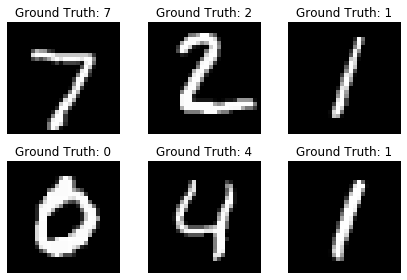

In [3]:
##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='./datasets', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./datasets', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
# let's see some digits
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("shape: \n", example_data.shape)
fig = plt.figure()
for i in range(6):
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(example_data[i][0], cmap='gray', interpolation='none')
    ax.set_title("Ground Truth: {}".format(example_targets[i]))
    ax.set_axis_off()
plt.tight_layout()

In [4]:
##########################
### MODEL
##########################

class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        # generator: z [vector] -> image [matrix]
        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )
        
        # discriminator: image [matrix] -> label (0-fake, 1-real)
        self.discriminator = nn.Sequential(
            nn.Linear(IMG_SIZE, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)

In [5]:
# constant the seed
torch.manual_seed(random_seed)

# build the model, send it ti the device
model = GAN().to(device)

# optimizers: we have one for the generator and one for the discriminator
# that way, we can update only one of the modules, while the other one is "frozen"
optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

In [6]:
##########################
### Training
##########################

start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(NUM_EPOCHS):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        features = (features - 0.5) * 2.0  # normalize between [-1, 1]
        features = features.view(-1, IMG_SIZE).to(device) 
        targets = targets.to(device)

        # generate fake and real labels
        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)
        
        ### FORWARD PASS AND BACKPROPAGATION
        
        # --------------------------
        # Train Generator
        # --------------------------
        
        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device) # can also use Gaussian
        generated_features = model.generator_forward(z)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features)
        
        # here we use the `valid` labels because we want the discriminator to "think"
        # the generated samples are real
        gener_loss = F.binary_cross_entropy(discr_pred, valid)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        # --------------------------
        # Train Discriminator
        # --------------------------        
        
        discr_pred_real = model.discriminator_forward(features.view(-1, IMG_SIZE))
        real_loss = F.binary_cross_entropy(discr_pred_real, valid)
        
        # here we use the `fake` labels when training the discriminator
        discr_pred_fake = model.discriminator_forward(generated_features.detach())
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake)
        
        discr_loss = 0.5 * (real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        
        
        discr_costs.append(discr_loss)
        gener_costs.append(gener_loss)
        
        
        ### LOGGING
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.6838/0.7138
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 4.3840/0.0432
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 1.9350/0.0932
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 1.2844/0.2061
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 1.9026/0.1210
Time elapsed: 0.21 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 3.0769/0.1038
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 2.2545/0.2297
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 1.6195/0.2978
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 1.3532/0.3820
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 0.8324/0.4919
Time elapsed: 0.42 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 0.9838/0.3945
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 1.1632/0.3346
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 1.5950/0.2493
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 0.9661/0.4662
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 1.4429/0.3401
Time elapsed: 0.60 min
Epoch: 004/100 |

Epoch: 050/100 | Batch 400/469 | Gen/Dis Loss: 0.8386/0.6264
Time elapsed: 10.96 min
Epoch: 051/100 | Batch 000/469 | Gen/Dis Loss: 0.7738/0.6598
Epoch: 051/100 | Batch 100/469 | Gen/Dis Loss: 0.7897/0.6525
Epoch: 051/100 | Batch 200/469 | Gen/Dis Loss: 1.0262/0.6191
Epoch: 051/100 | Batch 300/469 | Gen/Dis Loss: 0.8058/0.6210
Epoch: 051/100 | Batch 400/469 | Gen/Dis Loss: 0.8964/0.6628
Time elapsed: 11.20 min
Epoch: 052/100 | Batch 000/469 | Gen/Dis Loss: 0.7546/0.6437
Epoch: 052/100 | Batch 100/469 | Gen/Dis Loss: 0.8014/0.6632
Epoch: 052/100 | Batch 200/469 | Gen/Dis Loss: 0.8867/0.6125
Epoch: 052/100 | Batch 300/469 | Gen/Dis Loss: 0.8593/0.6246
Epoch: 052/100 | Batch 400/469 | Gen/Dis Loss: 1.0143/0.6210
Time elapsed: 11.46 min
Epoch: 053/100 | Batch 000/469 | Gen/Dis Loss: 0.8539/0.6260
Epoch: 053/100 | Batch 100/469 | Gen/Dis Loss: 0.7258/0.6664
Epoch: 053/100 | Batch 200/469 | Gen/Dis Loss: 0.8724/0.6416
Epoch: 053/100 | Batch 300/469 | Gen/Dis Loss: 0.8666/0.6325
Epoch: 053/10

Epoch: 100/100 | Batch 200/469 | Gen/Dis Loss: 0.8108/0.6150
Epoch: 100/100 | Batch 300/469 | Gen/Dis Loss: 0.8266/0.6527
Epoch: 100/100 | Batch 400/469 | Gen/Dis Loss: 0.8515/0.6409
Time elapsed: 22.84 min
Total Training Time: 22.84 min


(-2344.9500000000003, 49243.95)

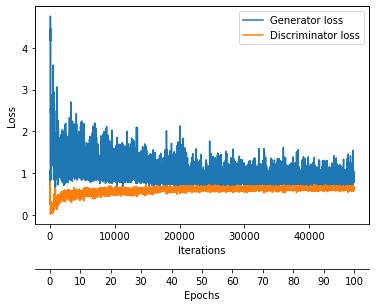

In [7]:
##########################
### Evaluation
##########################

ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

# Set scond x-axis
ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())

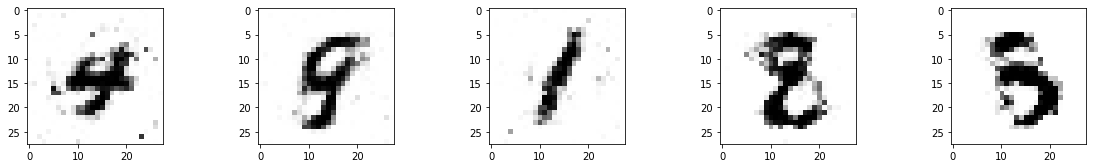

In [11]:
##########################
### VISUALIZATION
##########################

model.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')

## <img src="https://img.icons8.com/dusk/64/000000/layers.png" style="height:50px;display:inline"> Deep Convolutional GANs (DCGANs)
---
* Key ideas:
    * Replace fully-connected (FC) hidden layers with convolutions.
        * Use fractional/dialated convolutions (to perform the up-convolution from vectors to images).
    * Use *Batch Normalization* after each layer.
    * Activations:
        * Hidden layers are activated with ReLUs.
        * Output layer is activated with Tanh (i.e, the pixel values are normalized between $[-1, 1]$).

<img src="./assets/tut_gan_dcgan.PNG" style="height:350px">

## <img src="https://img.icons8.com/ultraviolet/80/000000/mark-view-as-hidden.png" style="height:50px;display:inline"> The Latent Space
---
* As we learn how to transform a latent vector, $z$, to images, we actullay learn a latent continuous space.
* This continuous spcae allows us to perform interpolation and arithmetics.
* As this space is continuous, unlike the original data (images), it was found that some operations (like summing) perform really well when done on the latent space.
* As you can see below, those operations were demonstrated in the paper <a href="https://arxiv.org/abs/1511.06434">Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, Alec Radford, Luke Metz, Soumith Chintala, ICLR 2016</a>

<img src="./assets/tut_gan_latent_space.PNG" style="height:450px">

## <img src="https://img.icons8.com/bubbles/80/000000/maracas.png" style="height:50px;display:inline"> Conditional GANs
---
* As you probably have noticed, we don't too much control over the latent space, e.g., with vanilla-GAN trained on MNIST we can't control what digit we are generating.
* **Conditional-GANs** - a simple modification to the original GAN framework that *conditions* the model on additional information for better multi-modal learning.
* In practice, we usually use the labels of the datasets to perform the conditioning.
    * For example, on MNIST we will use the one-hot vector representation of the digit ($1 \rightarrow [0,1,0,0,0,0,0,0,0,0]$) along with the images from that class.
* Leads to many practical applications of GANs when we have *explicit supervision available*.
* There is more than one way to perform conditioning, some approaches are presented below.

<img src="./assets/tut_gan_cgans.png" style="height:300px">

* <a href="https://arxiv.org/abs/1411.1784">Conditional Generative Adversarial Nets, Mehdi Mirza, Simon Osindero</a>
* <a href="https://assemblingintelligence.wordpress.com/2017/05/10/conditional-gans/">Conditional GANs</a>

## <img src="https://img.icons8.com/dusk/64/000000/today.png" style="height:50px;display:inline"> GANs Today
---
* GANs are **HARD to train** and many researche studies try to improve training stability.
* **WGAN** - Wasserstein GANs use the Wasserstein (Earth Movers) distance as the loss function. Training is more stabilized than vanilla-GAN.
    * **WGAN-GP** - improves upon the original WGAN by using *Gradient Penalty* in the loss function (instead of *value clipping*)
    * <a href="https://arxiv.org/abs/1701.07875">WGAN Paper</a>, <a href="https://github.com/Zeleni9/pytorch-wgan">PyTorch Code</a>
    * <a href="https://arxiv.org/abs/1704.00028">WGAN-GP Paper</a>, <a href="https://github.com/Zeleni9/pytorch-wgan">PyTorch Code</a>
* **EBGAN** - Energy-Based GANs use *autoencoders* in their architecture (with the autoencoder loss).
    * <a href="https://arxiv.org/abs/1609.03126">EBGAN Paper</a>, <a href="https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/ebgan/ebgan.py">PyTorch Code</a>
* **BEGAN** - Boundary Equilibrium GANs combines *autoencoders* and Wassertein distance to balance the generator and discriminator during training.
    * <a href="https://arxiv.org/abs/1703.10717">BEGAN Paper</a>, <a href="https://github.com/anantzoid/BEGAN-pytorch">PyTorch Code</a>
* **Mimicry** - a lightweight PyTorch library aimed towards the reproducibility of GAN research - <a href="https://github.com/kwotsin/mimicry">GitHub</a>

### <img src="https://img.icons8.com/nolan/64/to-do.png" style="height:40px;display:inline"> Tips for Training GANs
---
All tips are here: <a href="https://github.com/soumith/ganhacks">Tips for Training GANs</a>
* Normalize the inputs - usually between $[-1, 1]$. Use TanH for the Generator output.
* Use the modified loss function to avoid the vanishing gradients.
* Use a spherical Z - sample from a Gaussian distribution instead of uniform distribution.
* BatchNorm (when batchnorm is not an option use instance normalization).
* Avoid Sparse Gradients: ReLU, MaxPool - the stability of the GAN game suffers if you have sparse gradients.
    * LeakyReLU is good (in both G and D)
    * For Downsampling, use: Average Pooling, Conv2d + stride
    * For Upsampling, use: PixelShuffle, ConvTranspose2d + stride

* Use Soft and Noisy Labels
    * Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample, if it is real, then replace the label with a random number between 0.7 and 1.2, and if it is a fake sample, replace it with 0.0 and 0.3.
    * Make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator
* Track failures early:
    * D loss goes to 0 -- failure mode.
    * Check norms of gradients: if they are over 100 things are not good...
    * When things are working, D loss has low variance and goes down over time vs. having huge variance and spiking.
* **Don't** balance loss via statistics (unless you have a good reason to)
    * For example, don't do that: `while lossD > A: train D` or `while lossG > B: train G`

## <img src="./assets/gen_anim_icon.gif" style="height:40px;display:inline"> Applications
---
* There has been great progress in GANs, and everyday there is "a new GAN".
* The current quality of the generations is almost indistinguishable from real images.
    * <a href="https://thispersondoesnotexist.com/">StyleGAN V2 - ThisPersonDoesNotExist.com</a>
    * <a href="https://github.com/lucidrains/stylegan2-pytorch">SyleGAN V2 - PyTorch Code</a>
* There are many appliactions which we do not cover, but we provide links to projects at the end of this tutorial. We encourage you to explore areas that you find interesting and integrate them in your homework and projects.

### <img src="https://img.icons8.com/doodle/96/000000/transition-both-directions--v1.png" style="height:50px;display:inline"> Image-to-Image Translation (Pix2Pix)
---
* Training is conditioned on the images from the source domain.
* Conditional GANs provide an effective way to handle many complex domains without worrying about designing structured loss functions explicitly.
    * These networks not only learn the mapping from input image to output image, but also learn a loss function to train this mapping.
* <a href="https://phillipi.github.io/pix2pix/">Project Page</a>
    * <a href="https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix">PyTorch Code on GitHub</a>
* <a href="https://affinelayer.com/pixsrv/">Edges-to-Cats Demo</a>

<img src="./assets/tut_gan_pix2pix.png" style="height:350px">

<img src="./assets/tut_gan_pix2pixarch.jpg" style="height:300px">

* <a href="https://neurohive.io/en/popular-networks/pix2pix-image-to-image-translation/">Image Source</a>

* Pix2pix uses a conditional generative adversarial network (cGAN) to learn a function to map from an input image to an output image. 
* The **Generator** transforms the input image to get the output image. 
* The **Discriminator** measures the similarity of the input image to an unknown image (either a target image from the dataset or an output image from the generator) and tries to guess if it real or fake.

### <img src="https://img.icons8.com/dusk/64/000000/process.png" style="height:50px;display:inline"> CycleGAN
---
* For many tasks, paired training data will not be available (like in Pix2Pix).
* **CycleGAN** -  an approach for learning to translate an image from a source domain $X$ to a target domain $Y$ in the absence of paired examples.
* The goal is to learn a mapping $G: X \to Y$ such that the distribution of images from $G(X)$ is indistinguishable from the distribution $Y$ using an adversarial loss.
* Because this mapping is highly under-constrained, it is coupled with an inverse mapping $F: Y \to X$ and introduce a cycle consistency loss to push $F(G(X)) \approx X$ (and vice versa). $$\text{Loss}_{cyc}(G, F, X, Y) = \frac{1}{m}\sum_{i=1}^m \left[\mid\mid F\left(G(x_i)\right) - x_i\mid\mid_1\right] + \left[\mid \mid G\left(F(y_i)\right) - y_i\mid \mid_1\right]$$
* The complete loss: $$ \text{Loss}_{full} = \text{Loss}_{adv} + \lambda  \text{Loss}_{cyc}$$
    * $\lambda =10$ in the original implementation.

* <a href="https://junyanz.github.io/CycleGAN/">Project Page</a>
    * <a href="https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix">PyTorch Code on GitHub</a>
    
    <img src="./assets/tut_gan_horse_zebra.gif" style="height:200px">

<img src="./assets/tut_gan_cycle_gan_arch.PNG" style="height:350px">

<img src="./assets/tut_gan_cyclegan_arch.png" style="height:300px">

* <a href="https://towardsdatascience.com/image-to-image-translation-using-cyclegan-model-d58cfff04755">Image Source</a>

<img src="./assets/tut_gan_cycle_gan.jpg" style="height:350px">

* Video: <a href="https://www.youtube.com/watch?v=lCR9sT9mbis">[CycleGAN] Rendering Cityscapes in GTA Style</a>

### <img src="https://img.icons8.com/dusk/64/000000/portrait.png" style="height:50px;display:inline"> Realistic Neural Talking Head Models
---
* In order to create a personalized talking head model, it usually requires training on a large dataset of images of a single person. 
* However, in many practical scenarios, such personalized talking head models need to be learned from a few image views of a person, potentially even a single image. 
* In the paper **"Few-Shot Adversarial Learning of Realistic Neural Talking Head Models"**, a system with such few-shot capability is presented. 
* The model performs lengthy meta-learning on a large dataset of videos, and after that it is able to frame few- and one-shot learning of neural talking head models of previously unseen people as adversarial training problems with high capacity generators and discriminators.
* <a href="https://arxiv.org/abs/1905.08233v1">Paper Link</a>
    * <a href="https://github.com/vincent-thevenin/Realistic-Neural-Talking-Head-Models">PyTorch Code on GitHub</a>

<img src="./assets/tut_gan_talking_head.PNG" style="height:450px">

<img src="./assets/tut_gan_living_portrait.gif" style="height:250px">

* <a href="https://papers.nips.cc/paper/8935-first-order-motion-model-for-image-animation">First Order Motion Model for Image Animation</a> - Aliaksandr Siarohin, Stéphane Lathuilière, Sergey Tulyakov, Elisa Ricci, Nicu Sebe - NeuroIPS 2019
    * <a href="https://github.com/AliaksandrSiarohin/first-order-model">Code and Colab Demo</a>
    
<img src="./assets/tut_gan_first_order_motion.PNG" style="height:300px">

### <img src="https://img.icons8.com/cute-clipart/64/000000/age.png" style="height:50px;display:inline"> Face Aging with Conditional GANs
---
* A GAN-based method for automatic face aging.
* This model puts emphasize on preserving the original person’s identity in the aged version of his/her face.
* Introduces a novel approach for "Identity-Preserving" optimization of GAN's latent vectors. 
* The objective evaluation of the resulting aged and rejuvenated face images is done by the state-of-the-art face recognition and age estimation solutions.
* <a href="https://arxiv.org/abs/1702.01983">Paper Link</a>
    * <a href="https://github.com/guyuchao/IPCGANs-Pytorch">PyTorch Code on GitHub</a>

<img src="./assets/tut_gan_face_age_arch.PNG" style="height:350px">

<img src="./assets/tut_gan_face_age.PNG" style="height:500px">

## <img src="https://img.icons8.com/cute-clipart/64/000000/cool.png" style="height:50px;display:inline"> Cool GAN Projects (with Code)
---
* <a href="https://github.com/nashory/gans-awesome-applications">gans-awesome-applications</a>
* <a href="https://github.com/znxlwm/pytorch-generative-model-collections">pytorch-generative-model-collections</a>

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject
* Introduction to GANs - <a href="https://www.youtube.com/watch?v=9JpdAg6uMXs"> Introduction to GANs, NIPS 2016 | Ian Goodfellow, OpenAI</a>
* Generative Models -  <a href="https://www.youtube.com/watch?v=5WoItGTWV54"> Stanford CS231n - Lecture 13 | Generative Models</a>
* Deep Generative Modeling - <a href="https://www.youtube.com/watch?v=yFBFl1cLYx8"> MIT 6.S191 (2019): Deep Generative Modeling </a>
* Face Editing - <a href="https://www.youtube.com/watch?v=dCKbRCUyop8"> Face editing with Generative Adversarial Networks </a>
* Wasserstein GANs - <a href="https://www.youtube.com/watch?v=31mqB4yGgQY"> Nuts and Bolts of WGANs, Kantorovich-Rubistein Duality, Earth Movers Distance </a>
* Energy-Based GANs - <a href="https://www.youtube.com/watch?v=x4sI5qO6O2Y"> Energy-Based Adversarial Training and Video Prediction, NIPS 2016 | Yann LeCun, Facebook AI Research </a>
* CycleGAN - <a href="https://www.youtube.com/watch?v=T-lBMrjZ3_0"> Zebras, Horses & CycleGAN - Computerphile </a>
* Pix2Pix - <a href="https://www.youtube.com/watch?v=vrvwfFej_r4"> Neural Networks: pix2pix (Conditional GANs) </a>

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---

* Slides from <a href="http://slazebni.cs.illinois.edu/spring17/">CS 598 LAZ</a>
* Slides by Lihi Zelnik-Mannor
* Slides from <a href="http://ci2cv.net/16720b/">CMU - 16720B – Computer Vision</a>
* Some material from Alexander Amini and Ava Soleimany, MIT 6.S191: Introduction to Deep Learning, <a href="http://introtodeeplearning.com/">IntroToDeepLearning.com</a>
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com